# Sound Classification using Deep Learning


![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)

**Resuelto por: Carlos González Gamella 100364132**
#### Mount Google Drive


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Create a new folder in your drive and change to that directory as:
# /content/drive/My_Drive/new_dir_that_you_just_created_for_this_lab
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession2')

Mounted at /content/drive


#### Required Python libraries for the lab session
You may need to install librosa using pip as follows:
!pip install librosa==0.8.0


In [ ]:
import os
import sys
import pickle
import copy

from datetime import datetime
from tqdm import tqdm

import librosa
import librosa.display
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

## [!] INSTRUCTIONS FOR THE SUBMISSION OF THE LAB EXERCISES

The objective of this activity is that the student strengthens the concepts about Sound Classification using CNNs and LSTMs.

In order to do the lab session exercises, the student has to use Google Colab, execute this notebook for its resolution and answer several brief questions, including both extra code and text cells, if necessary.

Lab exercises will be done individually, never in groups.

**Each student must submit to Aula Global this notebook with the solutions to the lab exercises before the 19th November 2023 at 23:59h.**

---

# LAB SESSION 2
---

# Sound Classificaton with CNN-RNNs

### APPLICATIONS OF SPEECH, AUDIO, IMAGE AND VIDEO PROCESSING

### MASTER IN TELECOMMUNICATIONS ENGINEERING
### ACADEMIC COURSE 2023/2024

1. OBJECTIVE
2. DATABASE
3. READING AUDIO FILES AND FEATURE EXTRACTION
4. LOADING THE PRECOMPUTED FEATURES
5. DATA AUGMENTATION
6. UTILITY FUNCTIONS
7. CNN-RNN MODEL
8. SPLITTING AND NORMALIZING THE DATA
9. TRAINING AND TESTING THE SYSTEM

NOTE: you will find sections in this notebook called exercises, which are the ones you are expected to report for evaluation.

---
## 1. OBJECTIVE
---
The objective of this lab exercise is to implement an **environmental sound classification system based on Deep-Learning techniques**. This system takes and audio signal and provides the category to which it belongs.

The system is going to be implemented in **Pytorch** and uses log-mel spectrograms as input and **CNN-RNN** models. CNN-RNN consists of a combination of **Convolutional Neural Networks (CNNs)** and **Recursive Neural Networks (RNNs)**. In this lab, we are going to use a particular kind of RNNs, the **Long Short-Term Memory networks (LSTMs)**.

The main idea is that, as log-mel spectrograms are two dimensional signals, they can be visualized as images, so that CNNs are adequate for extraction more complex features from them. In addition, due to the sequential nature of log-mel spectrograms, LSTMs are suitable for performing a further processing prior to the classification itself.  

For building and assessing the system we are going to use urban sound excerpts from the **UrbanSound8K dataset**.

In this script, it is assumed that the audio database has been downloaded and the corresponding features have been generated in advance (see the script *LabSession2 - Sound Classfication - Preprocessing.ipynb* in Aula Global).



---
## 2. DATABASE
---
The database used in this lab session is the [UrbanSound8k dataset](https://urbansounddataset.weebly.com/urbansound8k.html) that contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes:

* air_conditioner
* car_horn
* children_playing
* dog_bark
* drilling
* enginge_idling
* gun_shot
* jackhammer
* siren
* street_music

This audio dataset is located in the directory *UrbanSound8K/audio/*.


---
## 3. READING AUDIO FILES AND FEATURE EXTRACTION
---

The following code shows an example of reading an audio file with the function **load** from the *librosa* library. Note that the sampling frequency of the audio file is 22050 Hz.

Sampling rate = 22050 Hz
Length of the audio signal = 66150 samples


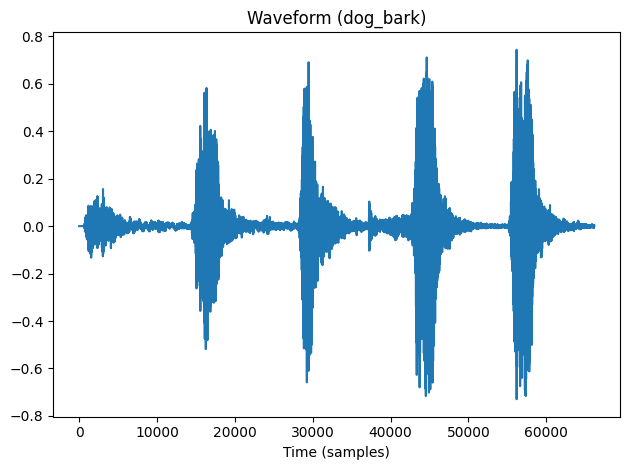

In [ ]:
# READING AUDIO FILES

# Reading an audio file from the database
SOUND_DURATION = 3.0    # fixed duration of an audio excerpt in seconds

audio_file = 'UrbanSound8K/audio/fold2/100652-3-0-0.wav';
audio, sampling_rate = librosa.load(audio_file, duration=SOUND_DURATION)
print('Sampling rate =', sampling_rate, 'Hz')
print('Length of the audio signal =', len(audio), 'samples')

# Plot the audio signal. It corresponds to the category 'dog_bark'
fig, ax = plt.subplots()
plt.plot(audio)
plt.title('Waveform (dog_bark)')
ax.set_xlabel('Time (samples)')
plt.tight_layout()
plt.show()

# Play the audio data
ipd.Audio(audio, rate=sampling_rate)

The following code computes the log-mel spectrogram of the previous audio file considering the following configuration:

* Frame period or hop length = 512 samples (512 / 22050 = 23.25 ms)
* Size (length) of the analysis window = 1024 samples (1024 / 22050 = 46.5 ms)
* Number of filters in the mel filterbank = 128

For the log-mel spectrogram computation, we have used the function **melspectrogram** from the module *feature* of the *librosa* package. This function has, among others, the following input arguments:

* y: speech signal
* sr: sampling frequency
* hop_length: frame period or hop length (in samples)
* win_length: window size (in samples)
* n_mels: number of filters in the mel filterbank

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (sr) indicates that 1 second corresponds to sr samples (in our case, as sr = 22050 Hz, 1 second corresponds to 22050 samples), the conversion from **samples** to **seconds** is performed by:

```
seconds = samples/sr = samples/22050
```


Dimensions of the log-mel spectrogram before the crop/padding process = 128 130
Dimensions of the log-mel spectrogram after the crop/padding process = 128 128


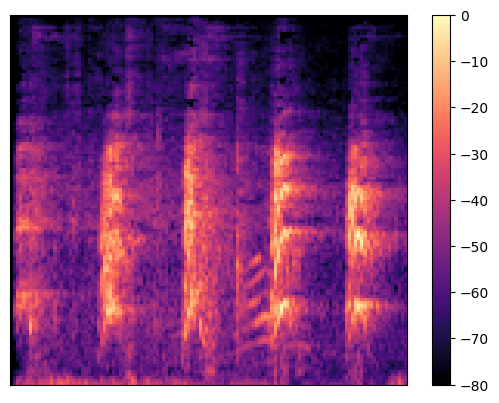

In [ ]:
# FEATURE EXTRACTION

# Extract the log-mel spectrogram of the audio file. This spectrogram is forced
# to have a fixed length that is determined by the configuration variable
# NUM_OF_FRAMES. Sequences longer than this quantity are cut, whereas
# sequences shorter than this quantity are padded at the beginning and the
# end with a predefined constant value.

# Configuration variables for log-mel spectrogram computation
WINDOW_LENGTH = 1024  # length of the analysis window in samples
HOP_LENGTH = 512      # number of samples between successive frames (frame period or hop length)
N_MEL = 128           # number of Mel bands to generate
NUM_OF_FRAMES = 128   # fixed duration in frames

# Mel spectrogram computation
melspectrogram = librosa.feature.melspectrogram(y=audio,
                                                sr=sampling_rate,
                                                hop_length=HOP_LENGTH,
                                                win_length=WINDOW_LENGTH,
                                                n_mels=N_MEL)

# Convert the power spectrogram to decibel units (log-mel spectrogram)
melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)

freq_dimension = melspectrogram_db.shape[0]
time_dimension = melspectrogram_db.shape[1]
print('Dimensions of the log-mel spectrogram before the crop/padding process =', freq_dimension, time_dimension)

# Pad or fix the length of spectrogram
if time_dimension != NUM_OF_FRAMES:
    melspectrogram_db = librosa.util.fix_length(melspectrogram_db,
                                                size=NUM_OF_FRAMES,
                                                axis=1,
                                                constant_values=(-80.0, -80.0))

freq_dimension = melspectrogram_db.shape[0]  # number of mel bands
time_dimension = melspectrogram_db.shape[1]  # length of the spectrogram
print('Dimensions of the log-mel spectrogram after the crop/padding process =', freq_dimension, time_dimension)

# Plot the log-mel spectrogram. It corresponds to the category 'dog_bark'
plt.figure()
librosa.display.specshow(melspectrogram_db)
plt.colorbar()



---
### [EXERCISE 1]
---

Answer the following questions:

1. Are we losing any information from the original audio signals by transforming them into log-mel spectrograms and giving the model just that? In other words, is it possible to recover the original audio signal from the log-mel spectrogram alone?

**Sí, al transformar las señales de audio en espectrogramas log-mel, perdemos cierta información de la señal original. Cuando calculamos el espectrograma log-mel, nos estamos centrando en la amplitud de la señal en el dominio de la frecuencia, ya que contiene la información más relevante y discriminativa. La fase, aunque contiene información, es más difícil de manejar y puede no aportar. Por tanto, debido a las operaciones no lineales y de reducción de la dimensionalidad involucradas, no es posible recuperar perfectamente la señal de audio original a partir del espectrograma log-mel solo. Aunque puede haber algunas aplicaciones en los que esto sea necesario, tendríamos que tener en cuenta la fase de la señal original**

2. If Deep Learning is about models learning what features to extract from the raw data, why are we not giving the network the raw audio signals?

**Aunque es cierto que las redes neuronales profundas tienen la capacidad de aprender características directamente de los datos brutos,es beneficioso proporcionar a la red solo las características más relevantes. Esto puede ayudar a la red a converger más rápido y tener en un rendimiento superior. Las señales de audio en bruto tienen una gran cantidad de datos, y la mayoría de estos datos pueden no ser relevantes para la tarea en cuestión. Al proporcionar espectrogramas log-mel, estamos dando a la red una representación que ya enfatiza las características importantes del audio.**

3. Explain the values of the dimensions of the resulting log-mel spectrograms before and after the crop/padding process.

**3.1**.  **Antes del proceso de crop/padding**  
- 128: Este número representa la cantidad de bandas de frecuencia mel. En otras palabras, al calcular el espectrograma mel, se han utilizado 128 filtros mel para descomponer la señal en 128 bandas de frecuencia diferentes que se alinean con la percepción auditiva humana.
- 130: Este número representa la cantidad de tramas o ventanas temporales en el espectrograma. Esencialmente, la señal de audio se ha dividido en 130 segmentos superpuestos y para cada segmento se ha calculado el espectrograma mel.

**3.2**.   **Después del proceso de crop/padding:**

- 128: La dimensión de frecuencia sigue siendo la misma, con 128 bandas mel.
- 128: Aquí es donde ha ocurrido el cambio. El espectrograma original tenía 130 tramas temporales, pero después del proceso de recorte/relleno, se ha ajustado a tener exactamente 128 tramas. Si el espectrograma original tuviera menos de 128 tramas, se habría "rellenado" (añadiendo valores constantes) para llegar a 128. Si tuviera más de 128 tramas, se habría "recortado" para ajustarse a este número.*

> HINT: Try to find information such as [this](https://arxiv.org/abs/1706.09559) analyzing the first two questions of this exercise.    


---
## 4. LOADING THE PRECOMPUTED FEATURES
---

The script *LabSession2 - Sound Classfication - Preprocessing.ipynb* (available in Aula Global) performs the previously described processes (database download and feature extraction) for the whole database.

After the execution of this script, you should find in your Google Drive directory the following items:

*   A directory called *UrbanSound8k* that contains the speech files in wav format
*   A zip file called *us8k_features.pkl* that contains the corresponding features (log-mel spectrograms)

As at this point, we do not need the audio files, in the following step we will only load the feature file *us8k_features.pkl*.

Also a custom dataset class for the management of this data is created.


In [ ]:
# LOADING THE PRECOMPUTED FEATURES
us8k_df = pd.read_pickle("us8k_features.pkl")
us8k_df.head()

,melspectrogram,label,fold
0,"[[-66.80671, -71.3875, -65.72835, -72.96344, -...",3,5
1,"[[-14.976936, -5.9584575, -12.821327, -16.3835...",2,5
2,"[[-20.649204, -18.456598, -6.6629205, -12.4990...",2,5
3,"[[-15.825411, -14.341511, -16.91633, -15.50906...",2,5
4,"[[-10.89318, -3.303462, -8.64709, -11.555507, ...",2,5


In [ ]:
# CUSTOM DATASET CLASS

DEFAULT_SAMPLE_RATE = 22050

class UrbanSound8kDataset(Dataset):
    def __init__(self, us8k_df, transform=None):
        assert isinstance(us8k_df, pd.DataFrame)
        assert len(us8k_df.columns) == 3

        self.us8k_df = us8k_df
        self.transform = transform

    def __len__(self):
        return len(self.us8k_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        spectrogram, label, fold = self.us8k_df.iloc[index]

        if self.transform is not None:
            spectrogram = self.transform(spectrogram)

        return {'spectrogram': spectrogram, 'label':label}

---
## 5. DATA AUGMENTATION
---

To compensate for the relatively small size of the dataset, two **data augmentation** techniques are used. Data augmentation is performed online by applying the techniques on the input log-mel spectrograms before they are fed to the model. Both techniques are applied with given probabilities, ensuring that the model is rarely trained on the exact same examples. Although this approach is much more time consuming, the effects of overfitting are significantly reduced.

The two main techniques used for the purposes of this lab exercise are:

* **Time Shifting**
* **Background Gaussian Noise**

The following code implements these transformations

In [ ]:
# TRANSFORMATIONS

class MyRightShift(object):
    """Shift the image to the right in time."""

    def __init__(self, input_size, width_shift_range, shift_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(width_shift_range, (int, float))
        assert isinstance(shift_probability, (float))

        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        if isinstance(width_shift_range, int):
            assert width_shift_range > 0
            assert width_shift_range <= self.input_size[1]
            self.width_shift_range = width_shift_range
        else:
            assert width_shift_range > 0.0
            assert width_shift_range <= 1.0
            self.width_shift_range = int(width_shift_range * self.input_size[1])

        assert shift_probability > 0.0 and shift_probability <= 1.0
        self.shift_prob = shift_probability

    def __call__(self, image):
        if np.random.random() > self.shift_prob:
          return image

        # create a new array filled with the min value
        shifted_image= np.full(self.input_size, np.min(image), dtype='float32')

        # randomly choose a start postion
        rand_position = np.random.randint(1, self.width_shift_range)

        # shift the image
        shifted_image[:,rand_position:] = copy.deepcopy(image[:,:-rand_position])

        return shifted_image

class MyAddGaussNoise(object):
    """Add Gaussian noise to the spectrogram image."""

    def __init__(self, input_size, mean=0.0, std=None, add_noise_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(mean, (int, float))
        assert isinstance(std, (int, float)) or std is None
        assert isinstance(add_noise_probability, (float))


        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        self.mean = mean

        if std is not None:
            assert std > 0.0
            self.std = std
        else:
            self.std = std

        assert add_noise_probability > 0.0 and add_noise_probability <= 1.0
        self.add_noise_prob = add_noise_probability


    def __call__(self, spectrogram):
      if np.random.random() > self.add_noise_prob:
          return spectrogram

      # set some std value
      min_pixel_value = np.min(spectrogram)
      if self.std is None:
        std_factor = 0.03     # factor number
        std = np.abs(min_pixel_value*std_factor)

      # generate a white noise spectrogram
      gauss_mask = np.random.normal(self.mean,
                                    std,
                                    size=self.input_size).astype('float32')

      # add white noise to the sound spectrogram
      noisy_spectrogram = spectrogram + gauss_mask

      return noisy_spectrogram

class MyReshape(object):
    """Reshape the image array."""

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))

        self.output_size = output_size

    def __call__(self, image):
      return image.reshape(self.output_size)


# build transformation pipelines for data augmentation
train_transforms = transforms.Compose([MyRightShift(input_size=128,
                                                    width_shift_range=13,
                                                    shift_probability=0.9),
                                       MyAddGaussNoise(input_size=128,
                                                       add_noise_probability=0.55),
                                       MyReshape(output_size=(1,128,128))])

test_transforms = transforms.Compose([MyReshape(output_size=(1,128,128))])



---
### [EXERCISE 2]
---

Answer the following questions:

1. Explain the data augmentation mechanism implemented in this class (*MyRightShift* and *MyAddGaussNoise* functions). What would you listen by playing the augmented samples in comparison with the original ones?

*   *MyRightShift*: **Esta clase implementa un desplazamiento temporal en el espectrograma.Mueve el espectrograma hacia la derecha en el eje temporal. Al escuchar un ejemplo de audio desplazado, se notaría como si el sonido comenzara después de un pequeño silencio al inicio, ya que se ha introducido un retraso.**

*   *MyAddGaussNoise*: **Esta clase añade ruido gaussiano al espectrograma con media 0 y desviación típica igual al valor mínimo de pixel multiplicado por 0,03. Al escuchar un ejemplo de audio con este tipo de aumento, se notaría un ruido de fondo adicional similar al de un ambiente ruidoso.**

2. As you can see, there is another transformation implemented in this class (*MyReshape*). What is the purpose of this transformation?  

**Se formatea el espectrograma a un tamaño especifico. El motivo de hacer esta transformación es asegurarse de que todos los espectrogramas tengan el mismo tamaño antes de ser alimentados a un modelo de deep learning. Después del aumento de datos, el espectrograma tiene 2 dimensiones, pero para la CNN necesitamos tener 3 dimensiones, por eso hacemos un cambio de forma (reshape) antes de la CNN. En nuestro caso, formatea el espectrograma a una forma de (1, 128, 128), lo que indica que tiene una sola "capa" y dimensiones espaciales de 128x128.**


---
## 6. UTILITY FUNCTIONS
---

There are two additional helper functions:

* *normalize_data*: it normalizes the data to zero mean and unit variance using the corresponding statistics of the training data

* *show_results*: it plots accuracy and loss values obtained during the training process

In [ ]:
# UTILITY FUNCTIONS

def normalize_data(train_df, test_df):
    # compute the mean and std (pixel-wise)
    mean = train_df['melspectrogram'].mean()
    std = np.std(np.stack(train_df['melspectrogram']), axis=0)

    # normalize train set
    train_spectrograms = (np.stack(train_df['melspectrogram']) - mean) / std
    train_labels = train_df['label'].to_numpy()
    train_folds = train_df['fold'].to_numpy()
    train_df = pd.DataFrame(zip(train_spectrograms, train_labels, train_folds), columns=['melspectrogram', 'label', 'fold'])

    # normalize test set
    test_spectrograms = (np.stack(test_df['melspectrogram']) - mean) / std
    test_labels = test_df['label'].to_numpy()
    test_folds = test_df['fold'].to_numpy()
    test_df = pd.DataFrame(zip(test_spectrograms, test_labels, test_folds), columns=['melspectrogram', 'label', 'fold'])

    return train_df, test_df

def show_results(history):
    """Show accuracy and loss graphs for train and test sets."""

    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.grid(linestyle='--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid(linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()

    print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
    print('\tMin validation loss: %.5f' % np.min(history['val_loss']))



## 7. CNN-RNN MODEL
---

The general architecture of the CNN-RNN model can be seen in the next Figure.

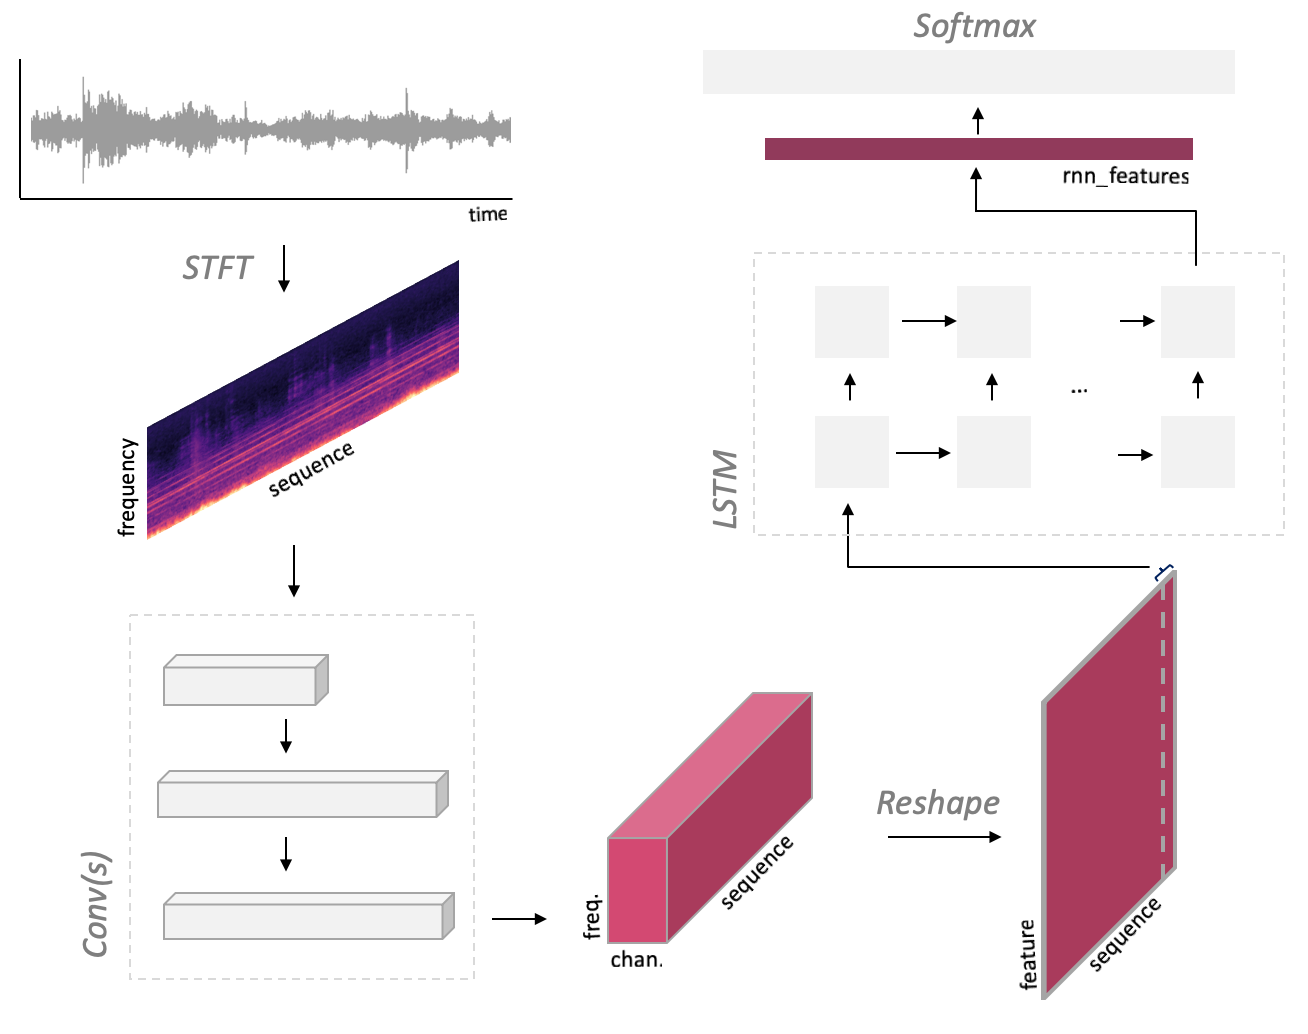

This is a general overview of the complete model:

1. The log-mel spectrogram is passed through a CNN that computes visual features for different time instants. At this point, a time instant is a bunch of columns from the log-mel spectrogram image. In particular, this CNN is composed of three CNN layers, with 32, 64 and 64 filters, respectively.

2. The visual features of each audio excerpt are reshaped and used as a sequence in a LSTM network composed of *hidden_size_rnn* nodes and *num_layers_rnn* layers. Note that LSTM node refers to the number of features in the hidden state.

3. As sound classification is a Many-to-One problem, only the last frames of the output of each of the LSTM nodes are retained.

4. The classifier itself is composed by a linear layer with *num_classes* output units, followed by a softmax activation function.

The following class implements this model together to the **train** and **evaluate** methods.




In [ ]:
# CNN-RNN MODEL

class CNN_RNN(nn.Module):
    def __init__(self, hidden_size_rnn, num_layers_rnn, num_classes, device):
        super(CNN_RNN, self).__init__()

        self.convs1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0),
            nn.Dropout(p=0.1)
        )

        self.recur = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=True)

        self.dense = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(hidden_size_rnn, eps=1e-05, momentum=0.1),
            nn.Linear(in_features=hidden_size_rnn, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

        # input x -> (batch, channel, freq, time)

        # cnn layer-1
        x = self.convs1(x)

        # cnn layer-2
        x = self.convs2(x)

        # cnn layer-3
        x = self.convs3(x)
        # x -> (batch, channel, freq, time)

        # transpose channel and time
        x = x.transpose(1,-1)
        # x -> (batch, time, freq, channel)

        # collapse height and channel
        sizes = x.size()
        x = x.reshape(sizes[0], sizes[1], sizes[2]*sizes[3])
        # xt -> (batch, time, freq*channel)

        # rnn layer
        x,_ = self.recur(x)
        # x -> (batch, time, lstm_out)

        # many-to-one rnn
        x = x[:,-1]
        # x -> (batch, lstm_out)

        # dense output layer
        x = self.dense(x)
        # x -> (batch, num_classes)

        # Softmax activation
        x = F.log_softmax(x, dim=1)
        # x -> (batch, num_classes)

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)
        self.eval()

        with torch.no_grad():
            for step, batch in enumerate(data_loader):
                X_batch = batch['spectrogram'].to(self.device)
                y_batch = batch['label'].to(self.device)

                outputs = self.forward(X_batch)

                # get batch loss
                loss = self.criterion(outputs, y_batch)
                running_loss = running_loss + loss

                # calculate batch accuracy
                predictions = torch.argmax(outputs, dim=1)
                correct_predictions = (predictions == y_batch).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)

            loss = running_loss.item() / (step+1)
            accuracy = running_acc.item() / (step+1)

        return loss, accuracy


The following code is useful for understanding the CNN-RNN architecture.

In [ ]:
### UNDERSTANDING THE CNN-RNN ARCHITECTURE

hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10
device = torch.device("cpu")
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)

# Lets go over each step in the forward method of the CNN_RNN model to
# understand the inputs and outputs of each submodule inside it

# generate a batch with a single image to use as model input (just noise
# with the proper dimensions)
# input x -> (batch, channel, freq, time)
x = torch.randn(2, 1, 128, 128)
print(x.shape)

# cnn layer-1
x = model.convs1(x)
# x -> (batch, channel, freq, time)
print(x.shape)

# cnn layer-2
x = model.convs2(x)
# x -> (batch, channel, freq, time)
print(x.shape)

# cnn layer-3
x = model.convs3(x)
# x -> (batch, channel, freq, time)
print(x.shape)

# transpose channel and time
x = x.transpose(1,-1)
# x -> (batch, time, freq, channel)
print(x.shape)

# collapse height and channel
sizes = x.size()
x = x.reshape(sizes[0], sizes[1], sizes[2]*sizes[3])
# xt -> (batch, time, freq*channel)
print(x.shape)

# rnn layer
x,_ = model.recur(x)
# x -> (batch, time, lstm_out)
print(x.shape)

# many-to-one rnn
x = x[:,-1]
# x -> (batch, lstm_out)
print(x.shape)

# dense output layer
x = model.dense(x)
# x -> (batch, num_classes)
print(x.shape)

# Softmax activation
x = F.log_softmax(x, dim=1)
# x -> (batch, num_classes)
print(x.shape)

print(model)


torch.Size([2, 1, 128, 128])
torch.Size([2, 32, 31, 31])
torch.Size([2, 64, 7, 7])
torch.Size([2, 64, 2, 5])
torch.Size([2, 5, 2, 64])
torch.Size([2, 5, 128])
torch.Size([2, 5, 64])
torch.Size([2, 64])
torch.Size([2, 10])
torch.Size([2, 10])
CNN_RNN(
  (convs1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convs2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convs3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (recur): LSTM(128, 64, num_layers=2,

---
### [EXERCISE 3]
---
After analyzing the architecture of the CNN-RNN model and the previous cell code, answer the following questions:

1. Explain the dimensions of the data at the output of the last CNN layer.

**Después de pasar por la tercera capa CNN (convs3), las dimensiones de los datos son (batch, 64, 2, 5). Esto significa que para cada muestra en el lote, hay 64 canales con una altura de 2 y un ancho de 5. **

2. What is the role of the recursive layer inside the CNN-RNN class?

**La capa recursiva, en este caso una LSTM, se utiliza para procesar secuencias temporales de datos. Las características extraídas por las capas CNN representan diferentes instantes de tiempo del espectrograma. La LSTM procesa estas características y captura las dependencias temporales presentes en el audio, lo cual es crucial para la clasificación de sonidos, donde la secuencia de características a lo largo del tiempo puede determinar la clase del sonido.**

3. Why does the first argument of the LSTM layer have to be 128?

**El primer argumento de la capa LSTM representa la dimensión de entrada, es decir, el número de características que se espera para cada paso de tiempo. Después de las transformaciones realizadas en los datos que salen de las capas CNN, las características se reorganizan y se comprimen para tener una forma de (batch, time, freq*channel). El tamaño de freq*channel es 2*64, que es 128, por lo que la LSTM espera 128 características para cada paso de tiempo.**

4. Why does the output of the "Many-to-One" step produce a 2-dimensional vector?

**El paso "Many-to-One" toma la secuencia completa de salidas de la LSTM y selecciona solo la salida del último paso de tiempo. Dado que estamos procesando un lote de datos, la salida es de la forma (batch, lstm_out), donde lstm_out es el número de nodos en el estado oculto de la LSTM. Esta es una representación condensada de toda la secuencia en un solo vector para cada muestra en el lote.**

5. What is the role of the softmax activation function?

**Se encarga de convertir las salidas del modelo en una distribución de probabilidad sobre las clases de salida. Cada elemento del vector de salida representará la probabilidad de que la entrada pertenezca a una clase específica. La suma de todas estas probabilidades es 1, lo que nos permite determinar cuál es la clase más probable para una entrada dada.**

---
## 8. SPLITTING AND NORMALIZING THE DATA
---

The original database is divided into 10 different folds. In this lab exercise, we are going to use folds 3-10 for training, fold 1 for testing and fold 2 for validation.

Once the division into training, validation and testing sets is performed, the data is normalized to mean zero and variance unity with respect to the training data.

In [ ]:
# SPLITTING AND NORMALIZING THE DATA

fold_k = 1
dataset_df = us8k_df

# split the data
train_df = dataset_df[dataset_df['fold'] > (fold_k+1)]
val_df = dataset_df[dataset_df['fold'] == fold_k+1]
test_df = dataset_df[dataset_df['fold'] == fold_k]

# normalize the data
train_df_norm, val_df_norm = normalize_data(train_df, val_df)
train_df_norm, test_df_norm = normalize_data(train_df, test_df)

---
## 9. TRAINING AND TESTING THE SYSTEM
---

The next code cell contains all the necessary to train and test the sound classification system.


Epoch 1/15
100%|██████████| 218/218 [00:07<00:00, 30.84it/s]
loss: 1.2195 - accuracy: 0.5502 - val_loss: 1.4145 - val_accuracy: 0.4408

Epoch 2/15
100%|██████████| 218/218 [00:04<00:00, 44.13it/s]
loss: 0.7914 - accuracy: 0.7394 - val_loss: 1.0645 - val_accuracy: 0.6205

Epoch 3/15
100%|██████████| 218/218 [00:04<00:00, 45.33it/s]
loss: 0.6959 - accuracy: 0.7729 - val_loss: 1.0164 - val_accuracy: 0.6350

Epoch 4/15
100%|██████████| 218/218 [00:06<00:00, 33.06it/s]
loss: 0.5313 - accuracy: 0.8121 - val_loss: 0.8647 - val_accuracy: 0.7165

Epoch 5/15
100%|██████████| 218/218 [00:06<00:00, 35.45it/s]
loss: 0.5480 - accuracy: 0.8088 - val_loss: 0.7501 - val_accuracy: 0.7712

Epoch 6/15
100%|██████████| 218/218 [00:06<00:00, 32.70it/s]
loss: 0.3727 - accuracy: 0.8767 - val_loss: 0.7352 - val_accuracy: 0.7377

Epoch 7/15
100%|██████████| 218/218 [00:04<00:00, 45.44it/s]
loss: 0.3385 - accuracy: 0.8845 - val_loss: 0.7239 - val_accuracy: 0.7444

Epoch 8/15
100%|██████████| 218/218 [00:04<00:0

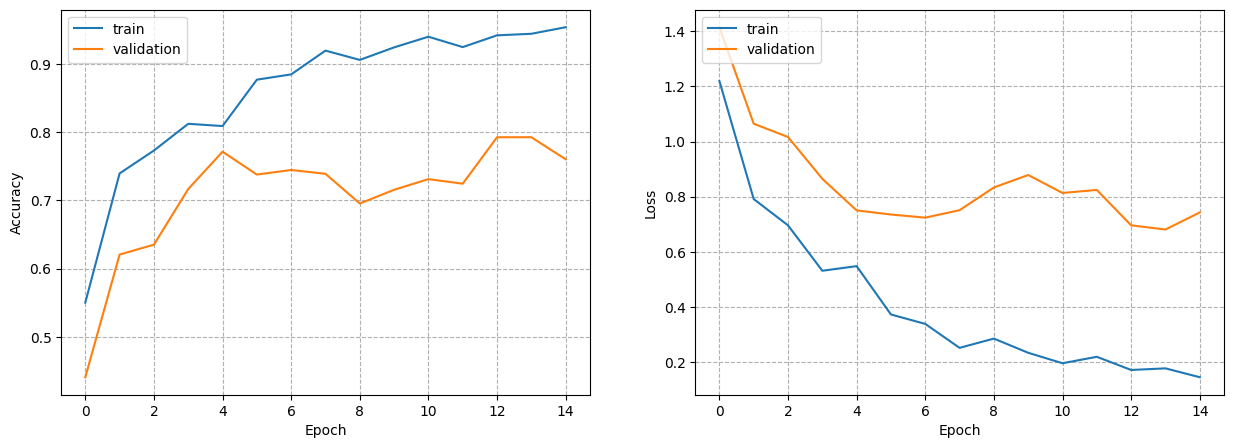

	Max validation accuracy: 79.2411 %
	Min validation loss: 0.68084


In [ ]:
# TRAINING THE SYSTEM

# training configuration
epochs = 15
batch_size = 32
num_of_workers = 0

# model configuration
hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10

# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# init model
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)

# init train data loader
train_ds = UrbanSound8kDataset(train_df_norm, transform=train_transforms)
train_loader = DataLoader(train_ds,
                          batch_size = batch_size,
                          shuffle = True,
                          pin_memory = True,
                          num_workers = num_of_workers)

# init valid data loader
val_ds = UrbanSound8kDataset(val_df_norm, transform=test_transforms)
val_loader = DataLoader(val_ds,
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# train the model
start_time = datetime.now()
history = model.fit(train_loader, epochs=epochs, val_loader=val_loader)
end_time = datetime.now() - start_time
print("\nTraining completed in time: {}".format(end_time))

# show the results
show_results(history)


In [ ]:
# TESTING THE SYSTEM

# init test data loader
test_ds = UrbanSound8kDataset(test_df_norm, transform=test_transforms)
test_loader = DataLoader(test_ds,
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# Test accuracy
score = model.evaluate(test_loader)
print("Test accuracy: %.4f%%" % (100 * score[1]))


Test accuracy: 64.1741%


---
### [EXERCISE 4]
---
           
1.  Modify the "Many-to-One" step of the CNN-RNN architecture for incorporating a Mean-Pooling mechanism.

2. Train and test the system with this modification. Does the model performance
improve by using the Mean-Pooling mechanism? Why do you think this happens?

En el caso original:
  
*  Max validation accuracy: 79.2411 %
*  Min validation loss: 0.68084
*  Test accuracy: 64.1741%

Cuando incorporo el mecanismo Mean-Pooling:

* Max validation accuracy: 77.9018 %
*	Min validation loss: 0.71240
* Test accuracy: 67.1875%

**Los resultados sugieren que el modelo con Mean-Pooling podría ser más general y menos propenso a sobreajustar a los datos de entrenamiento, ya que su rendimiento en el conjunto de test mejoró.**

**La *validation loss* aumentó con Mean-Pooling, lo que sugiere que el modelo pudo haber tenido más dificultades para ajustarse a los datos de entrenamiento en comparación con el modelo original. Sin embargo, esto no necesariamente es malo, ya que, como mencionamos, el modelo pudo haberse vuelto más general y menos propenso a sobreajustar.**

**El hecho de que la exactitud en test haya mejorado con Mean-Pooling indica que esta técnica podría ser beneficiosa para este conjunto de datos en particular. Al tomar la media de todos los estados de salida de la LSTM, el modelo podría estar capturando información más generalizada a lo largo de toda la secuencia, en lugar de depender demasiado de la información al final de la secuencia.**

In [ ]:
# CNN-RNN MODEL

class CNN_RNN(nn.Module):
    def __init__(self, hidden_size_rnn, num_layers_rnn, num_classes, device):
        super(CNN_RNN, self).__init__()

        self.convs1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0),
            nn.Dropout(p=0.1)
        )

        self.recur = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=True)

        self.dense = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(hidden_size_rnn, eps=1e-05, momentum=0.1),
            nn.Linear(in_features=hidden_size_rnn, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

        # input x -> (batch, channel, freq, time)

        # cnn layer-1
        x = self.convs1(x)

        # cnn layer-2
        x = self.convs2(x)

        # cnn layer-3
        x = self.convs3(x)
        # x -> (batch, channel, freq, time)

        # transpose channel and time
        x = x.transpose(1,-1)
        # x -> (batch, time, freq, channel)

        # collapse height and channel
        sizes = x.size()
        x = x.reshape(sizes[0], sizes[1], sizes[2]*sizes[3])
        # xt -> (batch, time, freq*channel)

        # rnn layer
        x,_ = self.recur(x)
        # x -> (batch, time, lstm_out)

        # many-to-one rnn
        #x = x[:,-1]
        x=x[:].transpose(1,-1)
        x = x = nn.functional.avg_pool1d(x, kernel_size=5, stride=1)
        x = x[:,:,-1]
        # x -> (batch, lstm_out)

        # dense output layer
        x = self.dense(x)
        # x -> (batch, num_classes)

        # Softmax activation
        x = F.log_softmax(x, dim=1)
        # x -> (batch, num_classes)

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)
        self.eval()

        with torch.no_grad():
            for step, batch in enumerate(data_loader):
                X_batch = batch['spectrogram'].to(self.device)
                y_batch = batch['label'].to(self.device)

                outputs = self.forward(X_batch)

                # get batch loss
                loss = self.criterion(outputs, y_batch)
                running_loss = running_loss + loss

                # calculate batch accuracy
                predictions = torch.argmax(outputs, dim=1)
                correct_predictions = (predictions == y_batch).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)

            loss = running_loss.item() / (step+1)
            accuracy = running_acc.item() / (step+1)

        return loss, accuracy


In [ ]:
# SPLITTING AND NORMALIZING THE DATA

fold_k = 1
dataset_df = us8k_df

# split the data
train_df = dataset_df[dataset_df['fold'] > (fold_k+1)]
val_df = dataset_df[dataset_df['fold'] == fold_k+1]
test_df = dataset_df[dataset_df['fold'] == fold_k]

# normalize the data
train_df_norm, val_df_norm = normalize_data(train_df, val_df)
train_df_norm, test_df_norm = normalize_data(train_df, test_df)


Epoch 1/20
100%|██████████| 218/218 [00:04<00:00, 44.64it/s]
loss: 1.1942 - accuracy: 0.5916 - val_loss: 1.3032 - val_accuracy: 0.5045

Epoch 2/20
100%|██████████| 218/218 [00:05<00:00, 43.19it/s]
loss: 0.9692 - accuracy: 0.6697 - val_loss: 1.2718 - val_accuracy: 0.5368

Epoch 3/20
100%|██████████| 218/218 [00:06<00:00, 36.08it/s]
loss: 0.5764 - accuracy: 0.8144 - val_loss: 0.9759 - val_accuracy: 0.6350

Epoch 4/20
100%|██████████| 218/218 [00:04<00:00, 44.71it/s]
loss: 0.6477 - accuracy: 0.7850 - val_loss: 0.9909 - val_accuracy: 0.6339

Epoch 5/20
100%|██████████| 218/218 [00:04<00:00, 44.48it/s]
loss: 0.4762 - accuracy: 0.8290 - val_loss: 0.8674 - val_accuracy: 0.7310

Epoch 6/20
100%|██████████| 218/218 [00:05<00:00, 36.45it/s]
loss: 0.4126 - accuracy: 0.8630 - val_loss: 0.8229 - val_accuracy: 0.7165

Epoch 7/20
100%|██████████| 218/218 [00:05<00:00, 42.36it/s]
loss: 0.3879 - accuracy: 0.8710 - val_loss: 1.0272 - val_accuracy: 0.6842

Epoch 8/20
100%|██████████| 218/218 [00:04<00:0

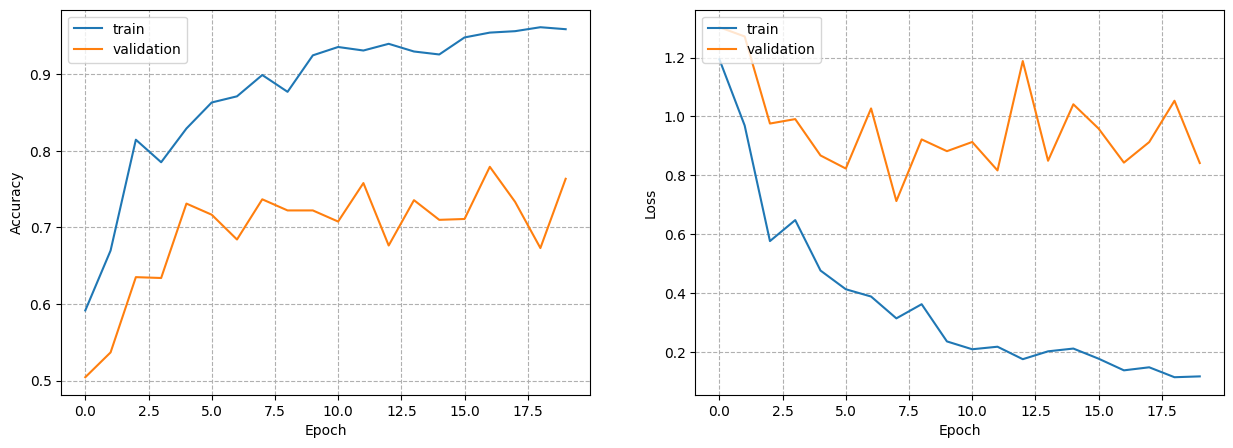

	Max validation accuracy: 77.9018 %
	Min validation loss: 0.71240


In [ ]:
# TRAINING THE SYSTEM

# training configuration
epochs = 20
batch_size = 32
num_of_workers = 0

# model configuration
hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10

# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# init model
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)

# init train data loader
train_ds = UrbanSound8kDataset(train_df_norm, transform=train_transforms)
train_loader = DataLoader(train_ds,
                          batch_size = batch_size,
                          shuffle = True,
                          pin_memory = True,
                          num_workers = num_of_workers)

# init valid data loader
val_ds = UrbanSound8kDataset(val_df_norm, transform=test_transforms)
val_loader = DataLoader(val_ds,
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# train the model
start_time = datetime.now()
history = model.fit(train_loader, epochs=epochs, val_loader=val_loader)
end_time = datetime.now() - start_time
print("\nTraining completed in time: {}".format(end_time))

# show the results
show_results(history)

In [ ]:
# TESTING THE SYSTEM

# init test data loader
test_ds = UrbanSound8kDataset(test_df_norm, transform=test_transforms)
test_loader = DataLoader(test_ds,
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# Test accuracy
score = model.evaluate(test_loader)
print("Test accuracy: %.4f%%" % (100 * score[1]))

Test accuracy: 67.1875%


---
### [EXERCISE 5]
---
           
1.  In some occassions, it is possible to get an extra boost in performance by allowing the recursive layer to use both, past and future samples for the present predictions. Take a look at the "bidirectional" option in the LSTM layer, and change your code to use it.

2. Train and test the system with this modification. Does the model performance
improve by using bidirectional LSTMs?

En el caso original:
  
*  Max validation accuracy: 79.2411 %
*  Min validation loss: 0.68084
*  Test accuracy: 64.1741%

En el caso bidireccional:

* Max validation accuracy: 68.5268 %
* Min validation loss: 0.83610
* Test accuracy: 68.6384%

**Como se observa en los datos, hay una mejora reseñable en el caso bidireccional respecto al caso anterior. Es el comportamiento esperado, puesto que ahora el modelo cuenta tanto con información tanto del pasado como del futuro.Sin embargo, en algunos contextos o conjuntos de datos, esta información adicional puede no ser útil o incluso puede introducir ruido en el proceso de decisión del modelo. Una posible razón para el decremento en la precisión de validación podría ser el sobreajuste.**

> HINT: Bidirectional recursive layers in Pytorch are implemented as two individual layers, each of them looking at the input data in reverse order from each other. Both individual outputs are concatenated into a final tensor. Thus, the dimension of the output gets doubled with respect to a non bidirectional LSTM. Note this fact has influence on the input size of the next dense layer.



In [ ]:
# CNN-RNN MODEL

class CNN_RNN(nn.Module):
    def __init__(self, hidden_size_rnn, num_layers_rnn, num_classes, device):
        super(CNN_RNN, self).__init__()

        self.convs1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(p=0.1)
        )

        self.convs3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=[0, 0]),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0),
            nn.Dropout(p=0.1)
        )
        #Se añade el modo bidirectional con True
        self.recur = nn.LSTM(128, hidden_size_rnn, num_layers=num_layers_rnn, batch_first=True, bidirectional=True)

        self.dense = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(hidden_size_rnn*2, eps=1e-05, momentum=0.1),
            nn.Linear(in_features=hidden_size_rnn*2, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

        # input x -> (batch, channel, freq, time)

        # cnn layer-1
        x = self.convs1(x)

        # cnn layer-2
        x = self.convs2(x)

        # cnn layer-3
        x = self.convs3(x)
        # x -> (batch, channel, freq, time)

        # transpose channel and time
        x = x.transpose(1,-1)
        # x -> (batch, time, freq, channel)

        # collapse height and channel
        sizes = x.size()
        x = x.reshape(sizes[0], sizes[1], sizes[2]*sizes[3])
        # xt -> (batch, time, freq*channel)

        # rnn layer
        x,_ = self.recur(x)
        # x -> (batch, time, lstm_out)

        # many-to-one rnn
        x=x[:].transpose(1,-1)
        x = x = nn.functional.avg_pool1d(x, kernel_size=5, stride=1)
        x = x[:,:,-1]
        # x -> (batch, lstm_out)
        #print(x.shape)

        # dense output layer
        x = self.dense(x)
        # x -> (batch, num_classes)

        # Softmax activation
        x = F.log_softmax(x, dim=1)
        # x -> (batch, num_classes)

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)
        self.eval()

        with torch.no_grad():
            for step, batch in enumerate(data_loader):
                X_batch = batch['spectrogram'].to(self.device)
                y_batch = batch['label'].to(self.device)

                outputs = self.forward(X_batch)

                # get batch loss
                loss = self.criterion(outputs, y_batch)
                running_loss = running_loss + loss

                # calculate batch accuracy
                predictions = torch.argmax(outputs, dim=1)
                correct_predictions = (predictions == y_batch).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)

            loss = running_loss.item() / (step+1)
            accuracy = running_acc.item() / (step+1)

        return loss, accuracy


In [ ]:
# SPLITTING AND NORMALIZING THE DATA

fold_k = 1
dataset_df = us8k_df

# split the data
train_df = dataset_df[dataset_df['fold'] > (fold_k+1)]
val_df = dataset_df[dataset_df['fold'] == fold_k+1]
test_df = dataset_df[dataset_df['fold'] == fold_k]

# normalize the data
train_df_norm, val_df_norm = normalize_data(train_df, val_df)
train_df_norm, test_df_norm = normalize_data(train_df, test_df)


Epoch 1/20
100%|██████████| 218/218 [00:05<00:00, 40.48it/s]
loss: 1.1004 - accuracy: 0.6251 - val_loss: 1.2701 - val_accuracy: 0.5190

Epoch 2/20
100%|██████████| 218/218 [00:06<00:00, 34.54it/s]
loss: 1.0578 - accuracy: 0.6720 - val_loss: 1.2719 - val_accuracy: 0.6027

Epoch 3/20
100%|██████████| 218/218 [00:06<00:00, 35.52it/s]
loss: 0.6335 - accuracy: 0.7768 - val_loss: 1.1226 - val_accuracy: 0.5949

Epoch 4/20
100%|██████████| 218/218 [00:05<00:00, 40.74it/s]
loss: 0.4729 - accuracy: 0.8483 - val_loss: 0.8976 - val_accuracy: 0.6719

Epoch 5/20
100%|██████████| 218/218 [00:04<00:00, 44.14it/s]
loss: 0.3901 - accuracy: 0.8683 - val_loss: 0.9670 - val_accuracy: 0.6306

Epoch 6/20
100%|██████████| 218/218 [00:05<00:00, 39.78it/s]
loss: 0.3251 - accuracy: 0.8941 - val_loss: 0.9862 - val_accuracy: 0.6384

Epoch 7/20
100%|██████████| 218/218 [00:06<00:00, 34.46it/s]
loss: 0.2997 - accuracy: 0.9040 - val_loss: 1.0350 - val_accuracy: 0.6473

Epoch 8/20
100%|██████████| 218/218 [00:08<00:0

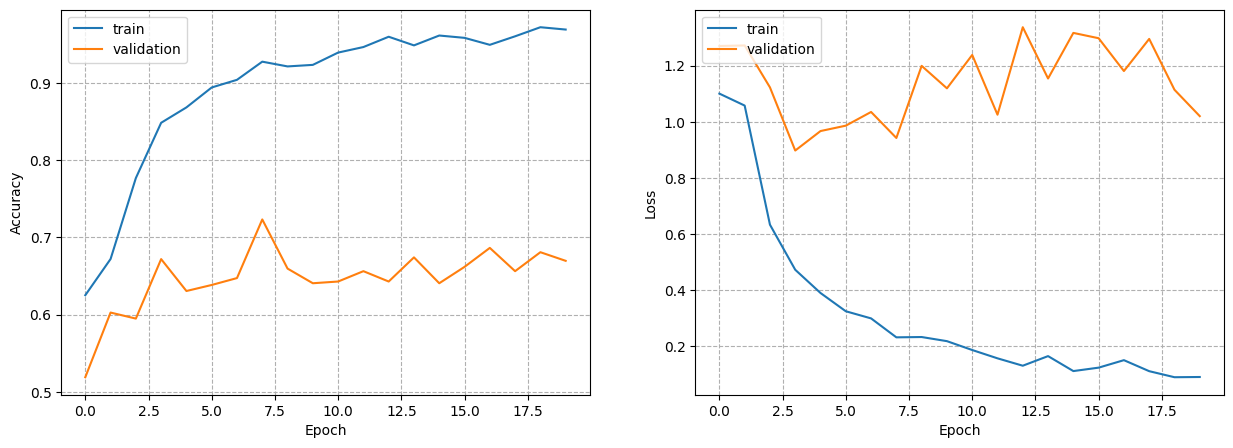

	Max validation accuracy: 72.3214 %
	Min validation loss: 0.89758


In [ ]:
# TRAINING THE SYSTEM

# training configuration
epochs = 20
batch_size = 32
num_of_workers = 0

# model configuration
hidden_size_rnn = 64
num_layers_rnn = 2
num_classes = 10

# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# init model
model = CNN_RNN(hidden_size_rnn, num_layers_rnn, num_classes, device).to(device)

# init train data loader
train_ds = UrbanSound8kDataset(train_df_norm, transform=train_transforms)
train_loader = DataLoader(train_ds,
                          batch_size = batch_size,
                          shuffle = True,
                          pin_memory = True,
                          num_workers = num_of_workers)

# init valid data loader
val_ds = UrbanSound8kDataset(val_df_norm, transform=test_transforms)
val_loader = DataLoader(val_ds,
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# train the model
start_time = datetime.now()
history = model.fit(train_loader, epochs=epochs, val_loader=val_loader)
end_time = datetime.now() - start_time
print("\nTraining completed in time: {}".format(end_time))

# show the results
show_results(history)


In [ ]:
# TESTING THE SYSTEM

# init test data loader
test_ds = UrbanSound8kDataset(test_df_norm, transform=test_transforms)
test_loader = DataLoader(test_ds,
                        batch_size = batch_size,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = num_of_workers)

# Test accuracy
score = model.evaluate(test_loader)
print("Test accuracy: %.4f%%" % (100 * score[1]))

Test accuracy: 67.9688%
